# Testing the Samplers

In [2]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import torch
import torch.nn as nn

sys.path.append('../source/')
from MALA import MALA
from RWHM import Metropolis_Hastings
from model import Model

In [3]:
X = pd.read_csv("../data/noisy_xor/data1/training/x.csv").to_numpy()
y = pd.read_csv("../data/noisy_xor/data1/training/y.csv").to_numpy().flatten()

X.shape, y.shape

((500, 2), (500,))

In [4]:
mlp = Model(sizes=[2, 2, 2], activations=[nn.ReLU(), nn.ReLU(), None])

In [16]:
N = 500
N_params = mlp.num_parameters()
N_steps = 100_000



In [6]:
def log_target(theta):
    log_target_tensor = mlp.compute_log_target(X, y, theta)
    log_target_array = log_target_tensor.cpu().detach().numpy()
    return log_target_array

def grad_log_target(theta):
    log_target_tensor = mlp.compute_log_target(X, y, theta)
    grad_tensor = mlp.compute_grad_log_target(log_target_tensor)
    grad_array = grad_tensor.cpu().detach().numpy()
    return grad_array

In [7]:
mu = np.zeros(N_params)
sigma = np.ones(N_params)
theta_0 = np.random.multivariate_normal(mean=mu, cov=np.diag(sigma))
print(theta_0)

[ 1.11484917  1.39163635 -1.34611397 -0.00198488  1.35184331  0.69313344
  0.0212771  -0.25318985 -0.71634117  1.36945152  1.56441014  0.53779926]


### RWHM

In [53]:
sigma_prop = 0.12

In [54]:
MH = Metropolis_Hastings(log_target,sigma_prop,theta_0)

sample_MH , acc_MH = MH.sample(N_steps)

print("Acceptance rate: ", acc_MH)

100%|██████████| 100000/100000 [00:56<00:00, 1781.36it/s]

Acceptance rate:  0.23332


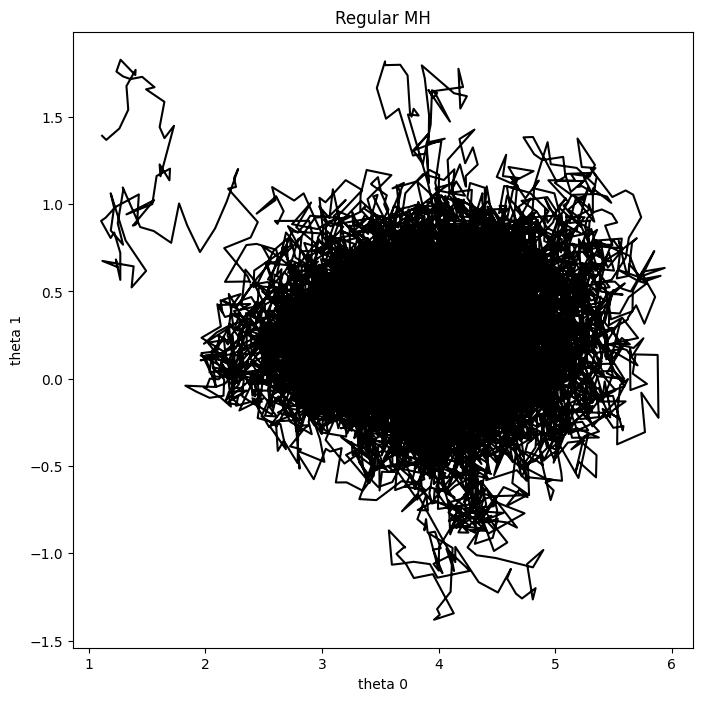

In [55]:
plt.figure(figsize=(8,8))
plt.plot(sample_MH[:,0], sample_MH[:,1], '-', color='black', alpha=1)
plt.xlabel('theta 0')
plt.ylabel('theta 1')
plt.title('Regular MH')
plt.show()

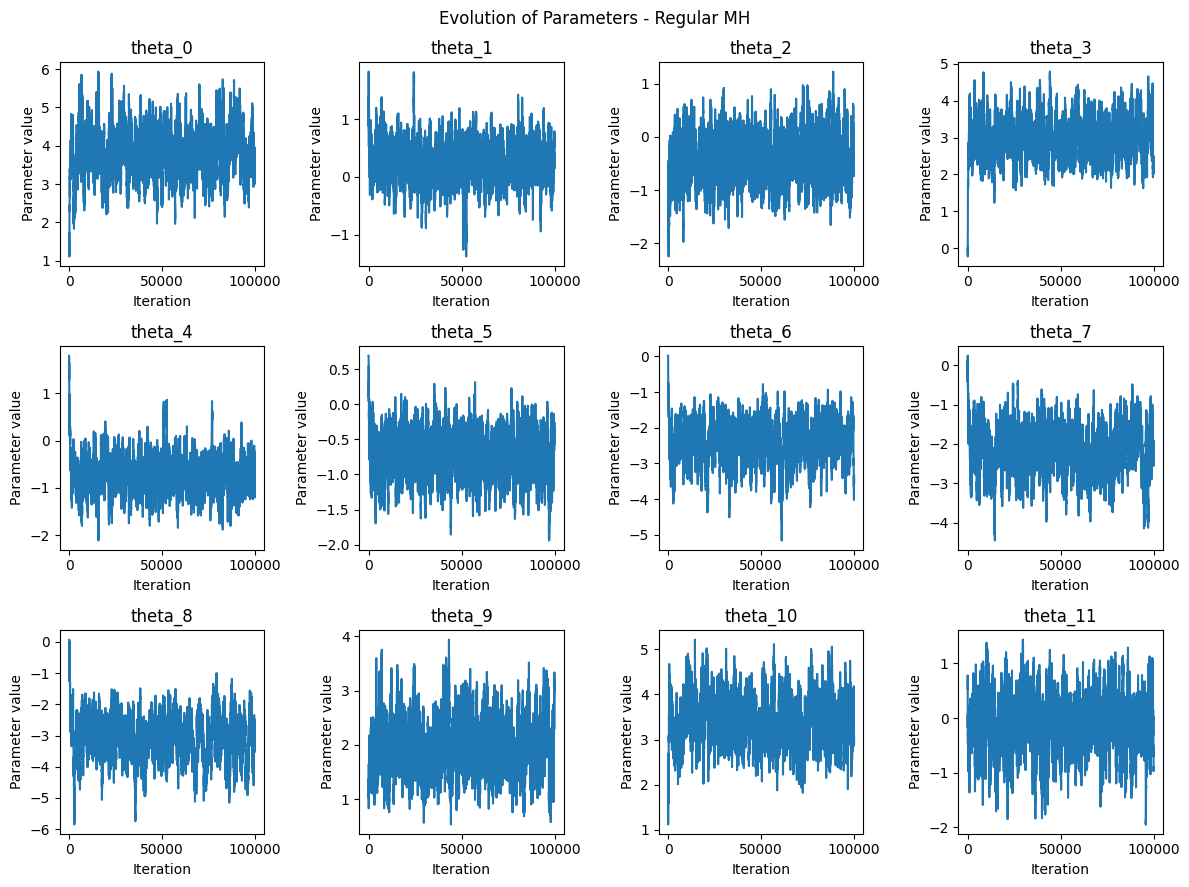

In [56]:
import matplotlib.pyplot as plt

# Plot evolution of each parameter along the chain

fig, axs = plt.subplots(3, 4, figsize=(12, 9))
fig.suptitle('Evolution of Parameters - Regular MH')

for i in range(N_params):
    row = i // 4
    col = i % 4
    axs[row, col].plot(sample_MH[:, i], label=f"theta_{i}")
    axs[row, col].set_xlabel('Iteration')
    axs[row, col].set_ylabel('Parameter value')
    axs[row, col].set_title(f'theta_{i}')

plt.tight_layout()
plt.show()


### MALA

In [58]:
epsilon_sq = np.square(0.08)

regular_MALA = MALA(log_target, grad_log_target, epsilon_sq, theta_0)
sample, acceptance = regular_MALA.sample(100000)
print(acceptance)

Running MALA sampler...


100%|██████████| 100000/100000 [03:24<00:00, 488.42it/s]

0.61691


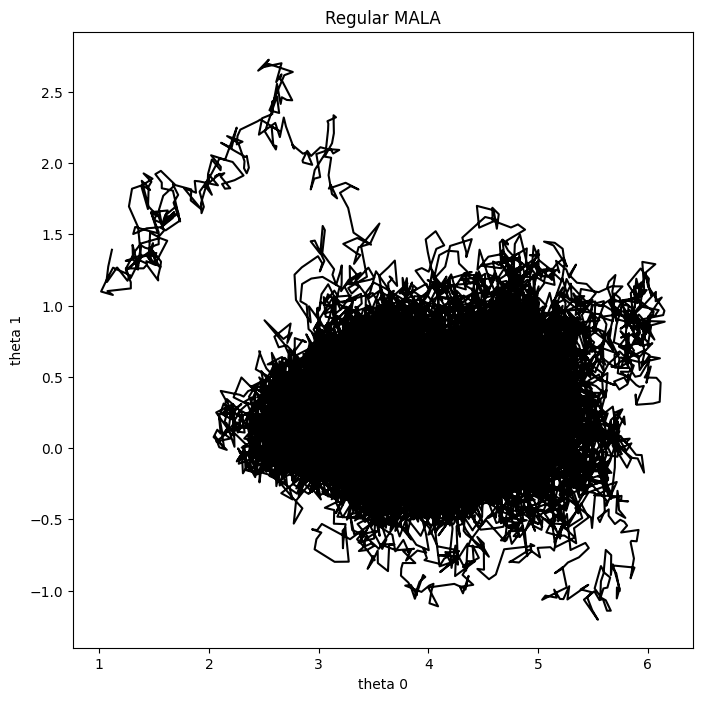

In [59]:
plt.figure(figsize=(8,8))
plt.plot(sample[:,0], sample[:,1], '-', color='black', alpha=1)
plt.xlabel('theta 0')
plt.ylabel('theta 1')
plt.title('Regular MALA')
plt.show()

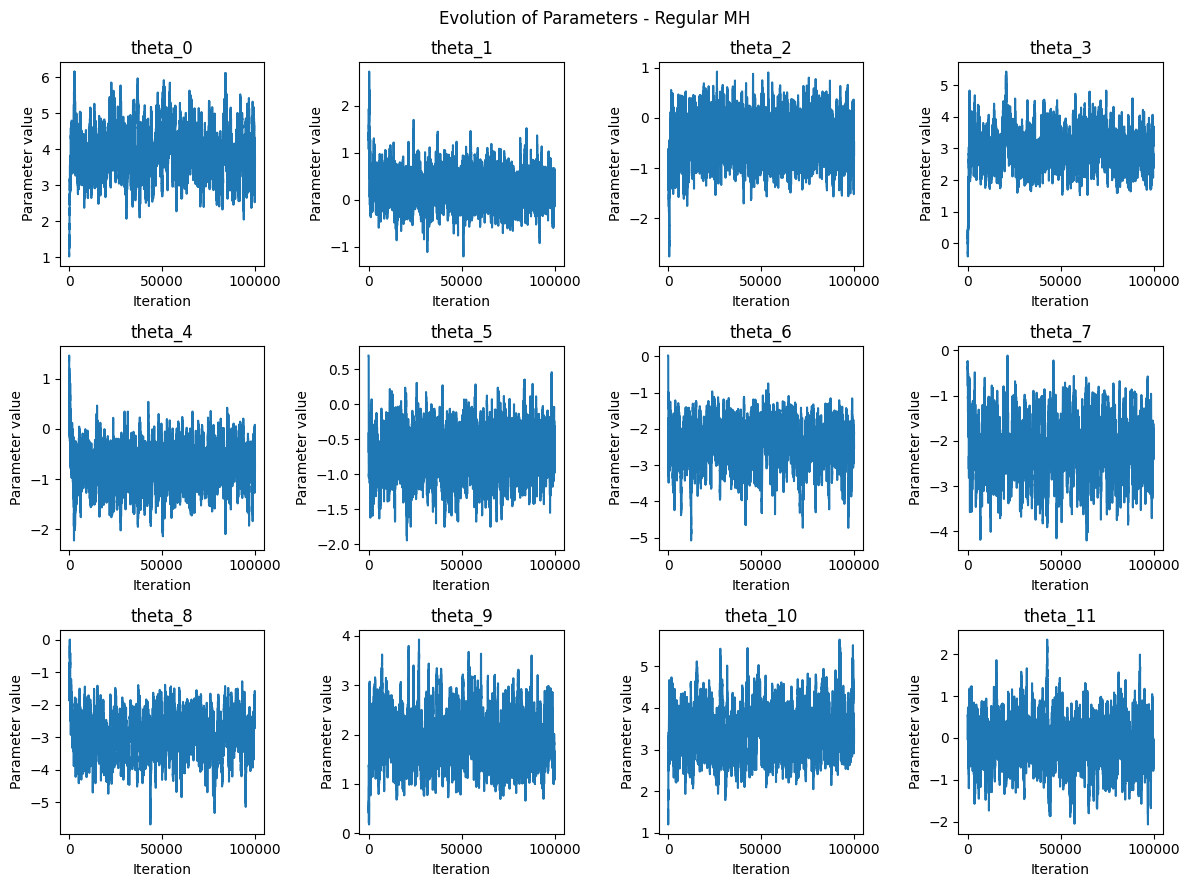

In [60]:
import matplotlib.pyplot as plt

# Plot evolution of each parameter along the chain

fig, axs = plt.subplots(3, 4, figsize=(12, 9))
fig.suptitle('Evolution of Parameters - Regular MH')

for i in range(N_params):
    row = i // 4
    col = i % 4
    axs[row, col].plot(sample[:, i], label=f"theta_{i}")
    axs[row, col].set_xlabel('Iteration')
    axs[row, col].set_ylabel('Parameter value')
    axs[row, col].set_title(f'theta_{i}')

plt.tight_layout()
plt.show()